# Python Imports

In [1]:
##### uncomment this if running from google.colab
##### !pip install plotly
##### !pip install pandas_schema
##### !pip install python-louvain
##### !pip install python-highcharts
##### !pip install bokeh
##### !pip install pydot

In [2]:
import re
import datetime
import csv
import random
from decimal import *
##### uncomment this if running from google.colab
##### from google.colab import files
##
import numpy as np
##
import pandas as pd
import pandas_schema
from pandas_schema import Column
from pandas_schema.validation import CustomElementValidation
##
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
##
import plotly.express as px
import plotly.graph_objects as go
##
import networkx as nx
import networkx.algorithms.community as nx_com
import community.community_louvain as community_louvain
from networkx.algorithms import community as community
##
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, FactorRange, HoverTool
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8, Plasma256, d3, Turbo256
from bokeh.transform import linear_cmap
from networkx.algorithms import community
from bokeh.models import EdgesAndLinkedNodes, NodesAndLinkedEdges
##
output_notebook(verbose=True)

Loading BokehJS ... 
 
 
 Using Settings: 
 
 
 Bokeh 
 version 
 2.4.3 
 
 
 BokehJS 
 js 
 ['https://cdn.bokeh.org/bokeh/release/bokeh-2.4.3.min.js', 'https://cdn.bokeh.org/bokeh/release/bokeh-gl-2.4.3.min.js', 'https://cdn.bokeh.org/bokeh/release/bokeh-widgets-2.4.3.min.js', 'https://cdn.bokeh.org/bokeh/release/bokeh-tables-2.4.3.min.js', 'https://cdn.bokeh.org/bokeh/release/bokeh-mathjax-2.4.3.min.js'] 
 
 
 css 
 []

# Utility Functions

In [3]:
default_date_format = '%d/%m/%Y'


#
def DownloadDataFrame(df, filename):
    df.to_csv(filename,
              encoding='utf-8-sig',
              index=False,
              quoting=csv.QUOTE_NONNUMERIC)
    files.download(filename)


#
def ResetDFIndex(df):
    df.index = pd.RangeIndex(len(df.index))
    df.index = range(len(df.index))
    return df


#
def CreateSubDataSet(df, columns, unique, sort):
    df = CreateDatasetFromColabUsers(df)[columns].copy()
    if (sort):
        df = df.sort_values(sort, ascending=True)
        if (unique):
            idx = df[sort].drop_duplicates().index
            event_types = df.loc[idx, :]
    return ResetDFIndex(event_types)


#
def ExtractEventTypes(df, download):
    event_type_ids = CreateSubDataSet(df, ['event_type_id', 'event_type_name'],
                                      True, 'event_type_id')
    #print(event_type_ids.shape)
    event_type_names = CreateSubDataSet(df,
                                        ['event_type_id', 'event_type_name'],
                                        True, 'event_type_name')
    #print(event_type_names.shape)
    if (len(event_type_ids) != len(event_type_names)):
        print("event_type_id and event_type_name counts are different.", len(event_type_ids), "ids", len(event_type_names), "names")
    if (download):
        DownloadDataFrame(event_type_ids, "event_type_ids.csv")
        DownloadDataFrame(event_type_names, "event_type_names.csv")
    return event_type_ids if len(event_type_ids) < len(event_type_names) else event_type_names


#
def check_decimal(dec):
    try:
        Decimal(dec)
    except InvalidOperation:
        return False
    return True


#
def check_int(num):
    try:
        int(num)
    except ValueError:
        return False
    return True


#
def check_string(test_string):
    return check_null(test_string) and len(str(test_string)) > 0


#
def check_date(date):
    try:
        datetime.datetime.strptime(date, default_date_format)
        return True
    except ValueError:
        return False
    #return check_string(date) and re.match(r'(\d{4})-(\d{2})-(\d{2}) (\d{1,2}):(\d{2})', date) is not None


#
print("check_date should be false: ", check_date(""))
print("check_date should be false: ", check_date("2022-05-18"))
print("check_date should be true: ", check_date("03/03/2013"))


def check_null(d):
    return not (d is None)


#
# define validation elements
decimal_validation = [
    CustomElementValidation(lambda d: check_decimal(d), 'invalid decimal')
]
int_validation = [
    CustomElementValidation(lambda i: check_int(i), 'invalid integer')
]
null_validation = [
    CustomElementValidation(lambda d: check_null(d), 'field cannot be null')
]
string_validation = [
    CustomElementValidation(lambda s: check_string(s), 'invalid string')
]
date_validation = [
    CustomElementValidation(lambda s: check_date(s), 'invalid date')
]


#
#
def validate_colab_events(file, parse_dates):
    print("validating colab_events file")
    # read the data
    data = ReadCSV(file, parse_dates)
    # define validation schema
    schema = pandas_schema.Schema([
        Column('event_id', null_validation + int_validation),
        Column('user_id', null_validation + int_validation),
        Column('description', string_validation),
        Column('status', null_validation + string_validation),
        Column('created_at', date_validation),
        Column('event_type_id', null_validation + int_validation),
        Column('event_type_name', null_validation + string_validation)
    ])
    # apply validation
    errors = schema.validate(data)
    errors_index_rows = [e.row for e in errors]
    data_clean = data.drop(index=errors_index_rows)
    if (len(errors) > 0):
        # save data
        #data_clean.update('"' + data_clean[['description', 'status', 'created_at', 'event_type_name']].astype(str) + '"')
        #data_clean['event_type_id'] = data_clean['event_type_id'].astype('int')
        #print(data.shape)
        #print(data_clean.shape)
        #DownloadDataFrame(data_clean, "colab_events_cleaned.csv")
        DownloadDataFrame(pd.DataFrame({'errors': errors}), "data_errors.txt")
        print("Errors found on CSV schema. Check out the data_errors.txt")
        return False
    else:
        print("File is clean")
        return True


#
def tipify_colab_events(df):
    df.fillna(-1, inplace=True)
    df['event_id'] = df['event_id'].astype('int')
    df['user_id'] = df['user_id'].astype('int')
    df['event_type_id'] = df['event_type_id'].astype('int')
    return df


#
def validate_colab_users(file, parse_dates):
    # read the data
    print("validating colab_users file")
    data = ReadCSV(file, parse_dates).head(1)
    # define validation schema
    schema = pandas_schema.Schema([
        Column('colab_user_id', null_validation + int_validation),
        Column('gender', null_validation),
        Column('birth_date', null_validation),
        Column('city_id', null_validation),
        Column('city_name', string_validation),
        Column('state_id', null_validation),
        Column('state_name', null_validation + string_validation),
        Column('created_at', date_validation),
        Column('last_sign_in_at', date_validation),
        Column('device', {})
    ])
    #print(data.columns)
    # apply validation
    errors = schema.validate(data)
    errors_index_rows = [e.row for e in errors]
    data_clean = data.drop(index=errors_index_rows)
    if (len(errors) > 0):
        # save data
        #print(data.shape)
        #print(data_clean.shape)
        #DownloadDataFrame(data_clean, "colab_users_cleaned.csv")
        DownloadDataFrame(pd.DataFrame({'errors': errors}), "user_errors.txt")
        print("Errors found on CSV schema. Check out the user_errors.txt")
        return False
    else:
        print("File is clean")
        return True


#
def tipify_colab_users(df):
    df.fillna("", inplace=True)
    df['colab_user_id'] = df['colab_user_id'].astype('int')
    df['city_id'] = df['city_id'].astype('int')
    df['state_id'] = df['state_id'].astype('int')
    return df


#
def tipify_colab_followers(df):
    df.fillna(-1, inplace=True)
    df['source'] = df['source'].astype('int')
    df['target'] = df['target'].astype('int')
    return df


#
def CreateDatasetFromColabEvents(df):
    dataset = df.copy()
    return dataset


#
#
def CreateDatasetFromColabUsers(df):
    dataset = df.copy()
    return dataset


#
def ReadCSV(filename, parse_dates):
    df = pd.read_csv(filename,
                     infer_datetime_format=True,
                     dayfirst=True,
                     parse_dates=parse_dates,
                     low_memory=False,
                     quoting=csv.QUOTE_NONNUMERIC,
                     quotechar='"')
    if (parse_dates):
        for field in parse_dates:
            try:
                df[field] = pd.to_datetime(df[field],infer_datetime_format=True,
                     dayfirst=True)
                df[field] = df[field].dt.strftime(default_date_format)
            except ValueError:
                message = "error parsing date {}".format(df[field])
                #print(message)
    #df[parse_dates].fillna(0, inplace=True)
    #df[parse_dates] = pd.to_datetime(df[parse_dates])
    #df[parse_dates] = df[parse_dates].dt.strftime('%d/%m/%Y')
    return df


#
def ReadAndValidateColabUsers(file):
    parse_dates = ['created_at', 'last_sign_in_at']
    if (validate_colab_users(file, parse_dates)):
        colab_users = tipify_colab_users(ReadCSV(file, parse_dates))
        return colab_users


#
def ReadAndValidateColabEvents(file):
    parse_dates = ['created_at']
    if (validate_colab_events(file, parse_dates)):
        colab_events = tipify_colab_events(ReadCSV(file, parse_dates))
        return colab_events
#

check_date should be false:  False
check_date should be false:  False
check_date should be true:  True


# Importando dados dos CSV

In [4]:
#cleaning up users file. not longer needed
#colab_users_url = "https://drive.google.com/uc?id=1FZhwHN_YK-WztJnU8ql2zzZ3JQsdRlVm&export=download" #New File (all data)
#colab_users_url = "https://drive.google.com/uc?id=1iRUwwuf1d-rAI2DhhNy4Z4CnLDchghzi&export=download" #New File (all data)
#colab_users = ReadCSV(colab_users_url, None)
#colab_users = tipify_colab_users(colab_users)
#colab_users['last_sign_in_at'].fillna("-1", inplace=True)
#colab_users['birth_date'] = pd.to_datetime(colab_users['birth_date'])
#colab_users['created_at'] = colab_users.apply(lambda row: row['created_at'][0:len("2013-03-03 15:48:07")] if row['created_at'] != "-1" else None, axis=1)
#colab_users['last_sign_in_at'] = colab_users.apply(lambda row: row['last_sign_in_at'] if row['last_sign_in_at'] != "-1" else None, axis=1)
#colab_users['birth_date'] = pd.to_datetime(colab_users['birth_date'])
#colab_users['birth_date'] = colab_users['birth_date'].dt.strftime('%Y-%m-%d')

#colab_users['device'] = colab_users.apply(lambda row: row['device'] if row['device'] != "-1" else None, axis=1)
#colab_users['last_sign_in_at'] = pd.to_datetime(colab_users['last_sign_in_at'])
#colab_users
#DownloadDataFrame(colab_users, "colab_users_cleaned.csv")

In [5]:
# arquivo com usuários e seguidores obtido a partir do merge dos 2 csvs
#colab_users_url = "https://drive.google.com/uc?id=1FZhwHN_YK-WztJnU8ql2zzZ3JQsdRlVm&export=download" #New File (all data) - Dirty
#colab_users_url = "https://drive.google.com/uc?id=1wNkAuqNSPTIY2dujmoy8r-oqV_EioiPi&export=download" #New File (all data) - Clean
colab_users_url = "https://drive.google.com/uc?id=1_rgS5CtYDFbU5viohhJueVKBz7C4zS7h&export=download" #05-20 File (all data) - Clean
colab_users = ReadAndValidateColabUsers(colab_users_url)
print(colab_users.shape)
colab_users.head(1)

validating colab_users file
File is clean
(50766, 10)


,colab_user_id,gender,birth_date,city_id,city_name,state_id,state_name,created_at,last_sign_in_at,device
0,1,male,1982-06-28,2916,Recife,16,Pernambuco,03/03/2013,12/05/2020,-1


In [6]:
#colab_events_url = "https://drive.google.com/uc?id=1_1JAZfGF2QfXCTHtEBEwvD-i0m201DNG&export=download" #2020-2022 Niteroi - Clean
#colab_events_url = "https://drive.google.com/uc?id=1jD3sY5jeDdCIb9M7EnCC6QVCI2RmKDqa&export=download" #05/19 file (all data)
#colab_events_url = "https://drive.google.com/uc?id=1pC9m4-k4e_I98MA_8G9mF-h6wCntd1Qu&export=download" #05/19 file (all data) - Clean
colab_events_url = "https://drive.google.com/uc?id=1Q-wSaTZGdP7xzsYFGV5E58feEN3e49yL&export=download"  #05/20 File(all data) - Clean
colab_events = ReadAndValidateColabEvents(colab_events_url)
print(colab_events.shape)
colab_events.head(1)

validating colab_events file
File is clean
(328876, 7)


,event_id,user_id,description,status,created_at,event_type_id,event_type_name
0,5,623,Carro estacionado na calçada em Edelson Cabele...,RECUSADO,06/03/2013,7575,Ponto de infração de trânsito recorrente


In [7]:
# arquivo com a rede identificando usuários e seus seguidores
#colab_followers_url = "https://drive.google.com/uc?id=17m7s0iejj6v6PH-lqHI0Sj87x7ZnyErE&export=download" #2020-2022 Niteroi - Clean
#colab_followers_url = "https://drive.google.com/uc?id=1UXakLielSxRMJW1ydztPAJdI3_dJ9rY7&export=download" #New File (all data)
colab_followers_url = "https://drive.google.com/uc?id=1v7ex9cCzlyMMUjy-rZQuBCruXTXVVVSv&export=download" #05-20 File (all data)
colab_followers = tipify_colab_followers(ReadCSV(colab_followers_url, ['created_at', 'updated_at', 'deleted_at']))
print(colab_followers.shape)
colab_followers.head(5)

(164074, 5)


,source,target,created_at,updated_at,deleted_at
0,32754,37001,13/08/2014,13/08/2014,-1
1,75852,50671,05/04/2015,05/04/2015,-1
2,59623,90610,30/07/2015,30/07/2015,-1
3,102862,109765,23/11/2015,23/11/2015,-1
4,112365,109858,23/11/2015,23/11/2015,-1


# Extraindo tipo de eventos e ids

In [8]:
null_columns=colab_events.columns[colab_events.isnull().any()]
print(colab_events[colab_events.isnull().any(axis=1)][null_columns].head())
event_types = ExtractEventTypes(colab_events, False)
print(event_types.shape)
event_types

Empty DataFrame
Columns: []
Index: []
event_type_id and event_type_name counts are different. 1510 ids 167 names
(167, 2)


,event_type_id,event_type_name
0,3906,Acesso problemático ao estádio
1,4540,Aeroporto superlotado
2,1764,Agentes e Operadores de trânsito
3,9975,Aglomeração de pessoas
4,11219,"Agricultura, Pecuária e Desenvolvimento Rural"
...,...,...
162,1744,Ônibus danificado
163,1377,Ônibus fora do horário/rota
164,405,Ônibus superlotado
165,2913,Ônibus/trem/metrô danificado


# Agregando total de posts por user_id

In [9]:
events_by_user_count = colab_events.groupby(["user_id"])["event_id"].count().reset_index(name="events_created")
events_by_user_count.sort_values("events_created", ascending=False)

,user_id,events_created
35965,318649,12247
29012,240336,11609
44493,425243,5257
25100,216238,4448
21666,186310,4169
...,...,...
18718,161547,1
9282,92599,1
33330,281429,1
33329,281423,1


# Adicionando total de eventos criados no dataframe de usuários do colab

In [10]:
colab_users['events_created'] = colab_users['colab_user_id'].map(events_by_user_count.set_index('user_id')['events_created'].to_dict())
colab_users['events_created'].fillna(0, inplace=True)
colab_users['events_created'] = colab_users['events_created'].astype('int')
colab_users.sort_values("events_created", ascending=False).head(10)

,colab_user_id,gender,birth_date,city_id,city_name,state_id,state_name,created_at,last_sign_in_at,device,events_created
35362,318649,male,1985-04-14,3633,Mesquita,19,Rio de Janeiro,08/06/2020,17/05/2022,-1,12247
28639,240336,male,1974-04-09,3633,Mesquita,19,Rio de Janeiro,22/07/2019,03/05/2022,-1,11609
43726,425243,male,1975-10-02,3633,Mesquita,19,Rio de Janeiro,07/07/2021,19/05/2022,Dart/2.12 (dart:io),5257
24831,216238,male,1964-10-06,3633,Mesquita,19,Rio de Janeiro,25/02/2019,19/05/2022,samsung##SM-J701MT,4448
21470,186310,male,1971-12-01,3633,Mesquita,19,Rio de Janeiro,05/09/2018,19/05/2022,-1,4169
6472,76184,male,1992-05-06,3638,Niterói,19,Rio de Janeiro,26/03/2015,19/05/2022,-1,4018
20074,173657,male,1984-08-12,3183,Teresina,17,Piauí,08/03/2018,19/09/2021,-1,3656
3839,43341,male,1983-02-22,3638,Niterói,19,Rio de Janeiro,19/09/2014,19/05/2022,-1,3597
22014,194422,others,1995-10-07,3638,Niterói,19,Rio de Janeiro,09/10/2018,19/05/2022,Apple##iPhone - 9.3.2,2911
4395,56857,male,1982-01-28,5325,Santos,26,São Paulo,29/10/2014,19/05/2022,-1,1997


# Agregando total de posts por tipo de evento

In [11]:
events_by_type = colab_events.groupby(["event_type_name"])["event_id"].count().reset_index(name="total_events")
events_by_type.sort_values("total_events", ascending=False).reset_index(drop=True).head(10)

,event_type_name,total_events
0,Entulho na calçada/via pública,61785
1,Buraco nas vias,41200
2,Lâmpada apagada à noite,32907
3,Ponto de infração de trânsito recorrente,15873
4,Calçada irregular,14837
5,Mato alto,13459
6,Poda de árvore,12810
7,Descarte irregular de lixo,12685
8,Bueiro entupido,8825
9,Vazamento de água,7433


# Agregando total de posts por tipo e por user_id

In [12]:
events_by_event_type_name_user_count = colab_events.groupby(["user_id", "event_type_name"])["event_id"].count().reset_index(name="events_created")
events_by_event_type_name_user_count.sort_values("events_created", ascending=False)
#DownloadDataFrame(events_by_user_count, "events_by_user_count.csv")

,user_id,event_type_name,events_created
89218,318649,Entulho na calçada/via pública,11700
75177,240336,Entulho na calçada/via pública,11560
104400,425243,Entulho na calçada/via pública,5246
64991,216238,Entulho na calçada/via pública,3014
17263,76184,Lâmpada apagada à noite,2579
...,...,...,...
45927,156406,Foco de mosquito da dengue/zika,1
45926,156375,Descarte irregular de lixo,1
45925,156375,Aterro sanitário irregular,1
45922,156364,Entulho na calçada/via pública,1


# Histórico de postagens

In [13]:
# gráfico com frequencia de postagens
#
# convertendo o campo para datas
colab_events["created_at"] = pd.to_datetime(colab_events["created_at"], infer_datetime_format=True, dayfirst=True)
colab_events['created_at'] = colab_events['created_at'].dt.strftime('%d/%m/%Y')
# agrupando por data
history = colab_events.groupby(["created_at"])["event_id"].count().reset_index(name="events_created")
# aqui para plotagem correta, é necessario setar o índice do dataframe com o valor do campo created_at
type(history.index)
history_plt = history.copy()
history_plt.set_index('created_at', inplace=True)
history_plt.index = pd.to_datetime(history_plt.index, dayfirst=True, infer_datetime_format=True)
type(history_plt.index)
#agora que o indice está como data, podemos plotar os valores, ordenando por data de criaçao
history_plt = history_plt.sort_values(by="created_at", ascending=True)
history_plt=pd.DataFrame(history_plt)
#display(history_plt.plot(figsize=(20,8), grid=True,kind='line'))
history_plt

,events_created
created_at,
2013-03-06,1
2013-03-07,2
2013-03-08,7
2013-03-09,7
2013-03-10,1
...,...
2022-05-15,87
2022-05-16,304
2022-05-17,284


In [14]:
fig = px.line(data_frame=history_plt, x=history_plt.index, y="events_created")
fig.update_layout(title='Events created by date',
                   xaxis_title='Date',
                   yaxis_title='Events created')
fig.show()

In [15]:
#top 10 datas com mais postagens
history_plt.sort_values('events_created', ascending=False).head(10)

,events_created
created_at,
2021-03-11,525
2018-04-21,519
2019-06-06,463
2022-02-02,457
2022-02-15,455
2021-06-16,436
2021-04-13,427
2022-02-16,422
2020-02-19,414


# Histórico de postagens por categoria

In [16]:
history_by_event_type_name = colab_events.groupby(["created_at", "event_type_name"])["event_id"].count().reset_index(name="events_created")
history_by_event_type_name["created_at"] = pd.to_datetime(history_by_event_type_name["created_at"], infer_datetime_format=True, dayfirst=True)
print(history_by_event_type_name.shape)
history_by_event_type_name=history_by_event_type_name.sort_values("created_at", ascending=True)
history_by_event_type_name.set_index('created_at', inplace=True)
history_by_event_type_name.head(10)
#DownloadDataFrame(history_by_event_type_name, "history_by_event_type_name.csv")

(79459, 3)


,event_type_name,events_created
created_at,,
2013-03-06,Ponto de infração de trânsito recorrente,1
2013-03-07,Calçada irregular,1
2013-03-07,Ponto de infração de trânsito recorrente,1
2013-03-08,Ponto de infração de trânsito recorrente,4
2013-03-08,Semáforo quebrado,2
2013-03-08,Calçada irregular,1
2013-03-09,Buraco nas vias,1
2013-03-09,Calçada irregular,2
2013-03-09,Ocupação irregular de área pública,1


In [17]:
#history_by_event_type_name_plt = history_by_event_type_name.copy()
#history_by_event_type_name_plt = history_by_event_type_name.head(10000)
#filtrando por data. vamos pegar o primeiro mes do colab
events_2017 = history_by_event_type_name.loc['2017-01-01':'2017-12-31']
events_2018 = history_by_event_type_name.loc['2018-01-01':'2018-12-31']
events_2019 = history_by_event_type_name.loc['2019-01-01':'2019-12-31']
events_2020 = history_by_event_type_name.loc['2020-01-01':'2020-12-31']
events_2021 = history_by_event_type_name.loc['2021-01-01':'2021-12-31']
events_2022 = history_by_event_type_name.loc['2022-01-01':'2022-12-31']
#filter by year-month
#history_by_event_type_name_plt=history_by_event_type_name_plt.groupby([history_by_event_type_name_plt.index.strftime('%Y-%b'), "event_type_name"])['event_type_name', 'events_created'].sum(numeric_only=True).reset_index()
#filter by year
top10_events = events_by_type.head(5)['event_type_name'].values
def filterAndGetTop10(df):
  #df=df[df['event_type_name'].isin(top10_events)]
  df=df.groupby([df.index.strftime('%Y'), "event_type_name"])['event_type_name', 'events_created'].sum(numeric_only=True).reset_index()
  df['created_at'] = pd.to_datetime(df['created_at'])
  df = df.nlargest(10, 'events_created')
  df=df.sort_values(["created_at", 'events_created'], ascending=[True, False])
  df['created_at'] = df['created_at'].dt.strftime('%Y')
  #df=df.query('events_created>1000')
  return df
#history_by_event_type_name_plt = pd.concat([filterAndGetTop10(events_2017), filterAndGetTop10(events_2018), filterAndGetTop10(events_2019), filterAndGetTop10(events_2020), filterAndGetTop10(events_2021)])
#history_by_event_type_name_plt=
#history_by_event_type_name_plt
#DownloadDataFrame(history_by_event_type_name_plt, "history_by_event_type_name_plt.csv")

In [18]:
def plotBokehBars(df, title):
  categories = df['event_type_name'].unique()
  years = df['created_at'].unique()
  print("categories", len(categories))

  #List of used statistics
  stats = categories

  #Creating a dictionary of our data
  mdata = {}
  data=df

  for cat in stats:
    for year in years:
      mdata[f'{cat}_{year}'] = data.query(f'event_type_name=="{cat}" & created_at=="{year}" ')['events_created'].sum()

  x = [ (year, stat) for year in years for stat in stats ]
  counts = sum(zip(mdata[f'{cat}_{year}'] for year in years for cat in stats), ())
  counts=np.array(counts)
  counts2=[]
  indexes_to_remove=[]
  for index in range(0, len(counts)):
    if(counts[index] != 0):
      counts2.append(counts[index])
    else:
      indexes_to_remove.append(index)
  #
  for index in range(0, len(indexes_to_remove)):
    x.pop(index)

  #
  colors={}
  color_palette = np.asarray(Turbo256).tolist();
  for stat in stats:
    selection = random.randint(0, len(color_palette)-1)
    selected_color = color_palette.pop(selection)
    colors[stat] = selected_color
  #
  colors_s=[]
  for year,cat in x:
      #print("cat", cat, "color", colors)
      colors_s.append(colors[cat])
  #

  source = ColumnDataSource(data=dict(x=x, counts=counts2, color=colors_s))

  tooltips=[
              ("index", "$index"),
              ("Categoria", "@x"),
              ("Posts", "@counts"),
          ]
    

  p = figure(
            x_range=FactorRange(*x),
            tooltips=tooltips,
            tools="pan,wheel_zoom,zoom_in,zoom_out,save,reset",
            sizing_mode="stretch_width",
            title=title)

  #Plotting our vertical bar chart
  p.vbar(x='x', top='counts', width=1,fill_color='color',  source=source)

  #Enhancing our graph
  p.y_range.start = 0
  p.x_range.range_padding = .1
  p.xaxis.major_label_orientation = .9
  p.xgrid.grid_line_color = None

  show(p)
#esse grafico ficou ruim pq o bokeh nao permite scroll. 
#ai pra uma timeseries longa ele se torna meio ruim de utilizar. 
#3 bloco de codigo so pra plotar um grafico. deusmelivrew. vou ver outras opções
plotBokehBars(filterAndGetTop10(events_2017), "Top posts por Categoria - 2017")

categories 10


C:\Users\guine\AppData\Local\Temp\ipykernel_65732\2360219682.py:16: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [19]:
plotBokehBars(filterAndGetTop10(events_2018), "Top posts por Categoria - 2018")

categories 10


C:\Users\guine\AppData\Local\Temp\ipykernel_65732\2360219682.py:16: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [20]:
plotBokehBars(filterAndGetTop10(events_2019), "Top posts por Categoria - 2019")

categories 10


C:\Users\guine\AppData\Local\Temp\ipykernel_65732\2360219682.py:16: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [21]:
plotBokehBars(filterAndGetTop10(events_2020), "Top posts por Categoria - 2020")

categories 10


C:\Users\guine\AppData\Local\Temp\ipykernel_65732\2360219682.py:16: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [22]:
plotBokehBars(filterAndGetTop10(events_2021), "Top posts por Categoria - 2021")

categories 10


C:\Users\guine\AppData\Local\Temp\ipykernel_65732\2360219682.py:16: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



# Filtrando redes por cidade
O dataframe `colab_followers` contém a rede de usuários do colab (usuários e seus seguidores) no formato `[source,target]`, onde source é o id do usuário colab e o target e o id do usuário colab que ele segue. 

A partir desse dataframe, é possivel construir e plotar graficos que representem a rede e as suas conexões.

Por uma questao de tempo computacional, as redes foram cortadas por cidade, sendo escolhidas Recife, Caruaru, Niterói e Rio de Janeiro.

Os blocos a seguir fazem uma busca no dataframe de usuários registros da cidade, entao utilizam o resultado para filtrar o `colab_followers` para mostrar apenas a rede daqueles usuários.

Não está se levando em consideraçao nessa demonstraçao usuários de outra cidade que seguem usuários das cidades selecionadas.

# **Recife**

In [23]:
colab_users_recife = colab_users.query("city_name == 'Recife'")
user_ids = colab_users_recife["colab_user_id"].values
colab_network_recife = colab_followers.query("source in (@user_ids) or target in (@user_ids)").loc[colab_followers['deleted_at'] == -1]
colab_network_recife

,source,target,created_at,updated_at,deleted_at
32,2,2767,13/08/2014,13/08/2014,-1
118,281,45753,28/12/2014,28/12/2014,-1
203,2844,19082,30/07/2015,30/07/2015,-1
204,2844,26717,30/07/2015,30/07/2015,-1
205,2844,754,30/07/2015,30/07/2015,-1
...,...,...,...,...,...
164041,198706,203519,18/09/2019,18/09/2019,-1
164051,5255,198706,18/09/2019,18/09/2019,-1
164059,203519,198706,18/09/2019,18/09/2019,-1
164068,14168,100212,26/11/2019,26/11/2019,-1


# **Niteroi**

In [24]:
colab_users_niteroi = colab_users.query("city_name == 'Niterói'")
user_ids = colab_users_niteroi["colab_user_id"].values
colab_network_niteroi = colab_followers.query("source in (@user_ids) or target in (@user_ids)").loc[colab_followers['deleted_at'] == -1]
colab_network_niteroi

,source,target,created_at,updated_at,deleted_at
47,20666,64273,05/02/2015,05/02/2015,-1
48,20666,43600,05/02/2015,05/02/2015,-1
49,65771,22120,05/02/2015,05/02/2015,-1
50,65771,11488,05/02/2015,05/02/2015,-1
51,65771,59325,05/02/2015,05/02/2015,-1
...,...,...,...,...,...
163974,234727,118544,17/09/2019,17/09/2019,-1
163986,181688,234727,17/09/2019,17/09/2019,-1
163987,181688,135418,17/09/2019,17/09/2019,-1
164023,162145,181688,18/09/2019,18/09/2019,-1


# **Caruaru**

In [25]:
colab_users_caruaru = colab_users.query("city_name == 'Caruaru'")
user_ids = colab_users_caruaru["colab_user_id"].values
colab_network_caruaru = colab_followers.query("source in (@user_ids) or target in (@user_ids)").loc[colab_followers['deleted_at'] == -1]
colab_network_caruaru

,source,target,created_at,updated_at,deleted_at
11731,1845,2179,09/09/2014,09/09/2014,-1
26673,294,2179,04/04/2015,04/04/2015,-1
30680,5313,1738,20/04/2013,20/04/2013,-1
33970,18520,2179,21/07/2013,21/07/2013,-1
36727,3199,2179,08/12/2013,08/12/2013,-1
...,...,...,...,...,...
162354,186310,305118,05/08/2021,05/08/2021,-1
162378,305285,307121,24/04/2020,24/04/2020,-1
162613,186310,307382,05/08/2021,05/08/2021,-1
162781,186310,298727,05/08/2021,05/08/2021,-1


# **Rio de Janeiro**

In [26]:
colab_users_rj= colab_users.query("city_name == 'Rio de Janeiro'")
user_ids = colab_users_rj["colab_user_id"].values
colab_network_rj = colab_followers.query("source in (@user_ids) or target in (@user_ids)").loc[colab_followers['deleted_at'] == -1]
colab_network_rj

,source,target,created_at,updated_at,deleted_at
149,58906,85785,24/06/2015,24/06/2015,-1
232,64975,56299,06/04/2015,06/04/2015,-1
402,99701,1698,28/10/2015,28/10/2015,-1
403,99701,39618,28/10/2015,28/10/2015,-1
404,99701,979,28/10/2015,28/10/2015,-1
...,...,...,...,...,...
162966,442517,443341,06/08/2021,06/08/2021,-1
162968,347006,460257,16/02/2022,16/02/2022,-1
163177,663195,686520,12/05/2022,12/05/2022,-1
163209,663195,687029,12/05/2022,12/05/2022,-1


# Visualizaçao de Redes
Para visualizaçao das redes foi utilizado a lib networkx. 
Nesse exemplo é exibido a rede de Caruaru utilizando o matplotlib.

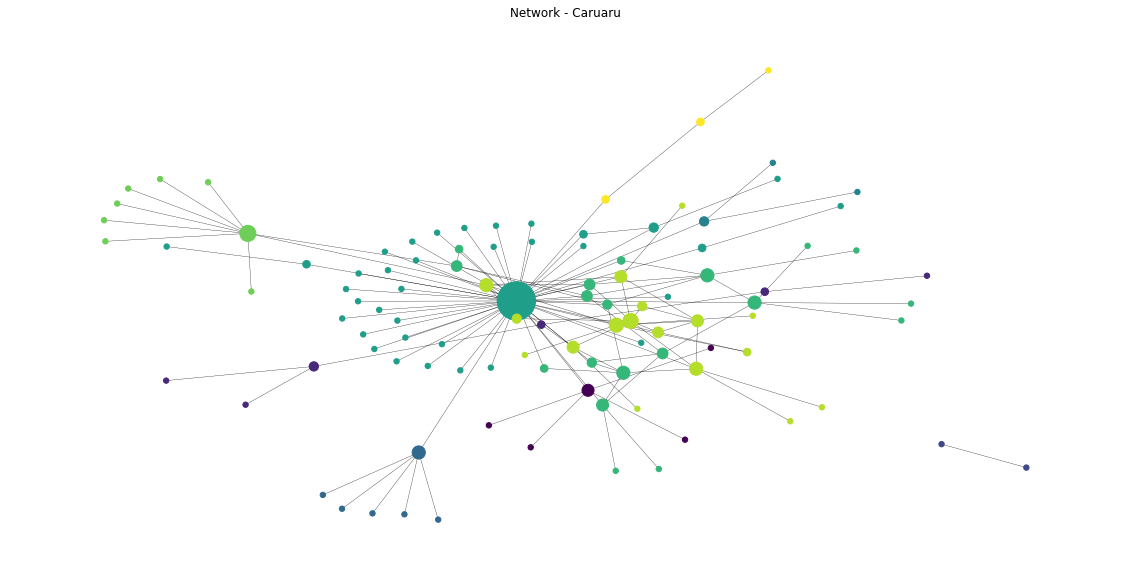

In [29]:
# create graph from data
G = nx.Graph()
G = nx.from_pandas_edgelist(colab_network_caruaru, 'source', 'target')

# centrality
deg_centrality = nx.degree_centrality(G)
centrality = np.fromiter(deg_centrality.values(), float)

# modularity
label = community_louvain.best_partition(G)
mod = community_louvain.modularity(label, G)
values = [label.get(node) for node in G.nodes()]


# plot
#pos = nx.spring_layout(G)
pos = nx.spring_layout(G, k=0.8*1/np.sqrt(len(G.nodes())), iterations=15, scale=20)
plt.figure(figsize=(20,10))
plt.title("Network - Caruaru")
plt.axis('off')
nx.draw(G, pos, node_color=values, node_size=centrality*3e3, width=0.3)

# Visualização Interativa de redes utilizando o Bokeh
https://docs.bokeh.org/en/latest/docs/user_guide/graph.html?highlight=networks

In [39]:

#Choose a title!
#title = 'Network - Rio de Janeiro'

# create graph from data
#G = nx.Graph()
#G = nx.from_pandas_edgelist(colab_users_rj, 'source', 'target')

#Establish which categories will appear when hovering over each node
#HOVER_TOOLTIPS = [("user_id", "@index")]

#Create a plot — set dimensions, toolbar, and title
#plot = figure(tooltips = HOVER_TOOLTIPS,
#              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
#            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object with spring layout
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
#network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0))

#Set node size and color
#network_graph.node_renderer.glyph = Circle(size=15, fill_color='skyblue')

#Set edge opacity and width
#network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
#plot.renderers.append(network_graph)

#show(plot)
#
def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]
#    
def get_adjusted_node_size(graph_network):
  degrees = nx.degree(graph_network)
  nx.set_node_attributes(graph_network, name='degree', values=dict(degrees))
  #
  centrality = nx.eigenvector_centrality_numpy(graph_network)
  nx.set_node_attributes(graph_network, name='centrality', values=centrality)
  centrality_values = []
  degree_values = []
  for (node) in centrality:
    centrality_values.append(centrality[node])
  max_centrality = max(centrality_values)
  min_centrality = min(centrality_values)
  i=0
  for (node, degree) in degrees:
    degree_values.append(degree)
    i=i+1
  max_degree = max(degree_values)
  print("max_degree", max_degree)
  #print("centrality_values", centrality_values)
  #print("max_centrality", max_centrality)
  #print("min_centrality", min_centrality)
  centrality_values=normalize(centrality_values, {'actual': {'lower': min_centrality, 'upper': max_centrality*2}, 'desired': {'lower': 5, 'upper': 100}})
  sizes = {}
  i=0
  for (node, degree) in degrees:
    sizes[node] = centrality_values[i]
    i=i+1
  #print("centrality_values_normalized", centrality_values)
  #print(sizes)
  adjusted_node_size = dict([(node, sizes[node]) for node, degree in degrees])
  nx.set_node_attributes(graph_network, name='adjusted_node_size', values=adjusted_node_size)
#
def plot_bokeh_network(graph_network, network_communities, title, palette):
  for component in list(nx.connected_components(graph_network)):
    if len(component)<3:
        for node in component:
            graph_network.remove_node(node)
  #
  get_adjusted_node_size(graph_network)
  # Create empty dictionaries
  modularity_class = {}
  modularity_color = {}
  #Loop through each community in the network
  for community_number, community in enumerate(network_communities):
      #For each member of the community, add their community number and a distinct color
      for name in community: 
          modularity_class[name] = community_number
          modularity_color[name] = palette[community_number%len(palette)]
  # Add modularity class and color as attributes from the network above
  nx.set_node_attributes(graph_network, modularity_class, 'modularity_class')
  nx.set_node_attributes(graph_network, modularity_color, 'modularity_color')
  #Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
  size_by_this_attribute = 'adjusted_node_size'
  color_by_this_attribute = 'modularity_color'
  #Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
  color_palette = Blues8
  #Choose colors for node and edge highlighting
  node_highlight_color = 'white'
  edge_highlight_color = 'black'
  #Establish which categories will appear when hovering over each node
  #Establish which categories will appear when hovering over each node
  HOVER_TOOLTIPS = [
          ("user_id", "@index"),
          ("Degree", "@degree"),
          ("Centrality", "@centrality"),
          ("Modularity Class", "@modularity_class"),
          ("Modularity Color", "$color[swatch]:modularity_color"),
  ]

  #Create a plot — set dimensions, toolbar, and title
  plot = figure(tooltips = HOVER_TOOLTIPS,
              sizing_mode="stretch_width",
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom', height=600, title=title)
  #

  #df = pd.DataFrame(index=graph_network.nodes(), columns=graph_network.nodes())
  #for row, data in nx.shortest_path_length(graph_network):
  #    for col, dist in data.items():
  #        df.loc[row,col] = dist
  #df = df.fillna(df.max().max())

  #layout = nx.spring_layout(graph_network, scale=10, weight='degree')
  #layout = nx.nx_agraph.graphviz_layout(graph_network)
  layout = nx.nx_pydot.graphviz_layout(graph_network, prog="neato")

  #Create a network graph object
  # https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
  network_graph = from_networkx(graph_network, layout, scale=25, k=len(graph_network.nodes())*1/np.sqrt(len(graph_network.nodes())), center=(0, 0))

  #Set node sizes and colors according to node degree (color as category from attribute)
  network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)
  #Set node highlight colors
  network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
  network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)

  #Set edge opacity and width
  network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.3, line_width=0.5)
  #Set edge highlight colors
  network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
  network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
  #
  #Highlight nodes and edges
  network_graph.selection_policy = NodesAndLinkedEdges()
  network_graph.inspection_policy = NodesAndLinkedEdges()
  #
  plot.renderers.append(network_graph)

  show(plot)
#
#get_adjusted_node_size(graph_rj)
#normalize(
    #[1, 0.7232322, 0.93832, 0.4344433],
    #{'actual': {'lower': 0, 'upper': 1}, 'desired': {'lower': 5, 'upper': 50}}
#)
#plot_bokeh_network(graph, communities, 'Network - Caruaru', d3['Category20'][20])

# Plotando uma rede simples
Plotando a rede de Caruaru utilizando cores para distinguir a centralidade da rede.
Esse foi o exemplo base da documentaçao do Bokeh, que foi evoluido para os exemplos a seguir.

In [31]:
# create graph from data
G = nx.Graph()
G = nx.from_pandas_edgelist(colab_network_caruaru, 'source', 'target')
#Calculate degree for each node and add as node attribute
degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='degree', values=degrees)
#Slightly adjust degree so that the nodes with very small degrees are still visible
number_to_adjust_by = 5
adjusted_node_size = dict([(node, degree+number_to_adjust_by) for node, degree in nx.degree(G)])
nx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)
#
#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8

#Choose a title!
title = 'Network - Caruaru'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("user_id", "@index"),
        ("Degree", "@degree")
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html\
network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0))

#Set node sizes and colors according to node degree (color as spectrum of color palette)
minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

plot.renderers.append(network_graph)

show(plot)

# Colab Network - Caruaru

In [40]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_caruaru, 'source', 'target')
communities = community.greedy_modularity_communities(graph)
plot_bokeh_network(graph, communities, 'Network - Caruaru', d3['Category20'][20])

max_degree 51


c:\Python310\lib\site-packages\bokeh\plotting\graph.py:122: UserWarning:

Node keys in 'layout_function' don't match node keys in the graph. These nodes may not be displayed correctly.



# Conexões da Rede - Caruaru

In [ ]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_caruaru, 'source', 'target')
leaderboard = {}
for x in graph.nodes:
 leaderboard[x] = len(graph[x])
s = pd.Series(leaderboard, name='connections')
df2 = s.to_frame().sort_values('connections', ascending=False)
df2

,connections
157493,51
322881,9
313537,8
288189,7
299406,6
...,...
216340,1
253661,1
313457,1
289871,1


# Colab Network - Rio de Janeiro

In [41]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_rj, 'source', 'target')
communities = community.greedy_modularity_communities(graph)
plot_bokeh_network(graph, communities, 'Network - Rio de Janeiro', d3['Category20'][20])

max_degree 312


# Conexões da Rede - Rio de Janeiro

In [42]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_rj, 'source', 'target')
leaderboard = {}
for x in graph.nodes:
 leaderboard[x] = len(graph[x])
s = pd.Series(leaderboard, name='connections')
df2 = s.to_frame().sort_values('connections', ascending=False)
df2

,connections
165510,312
116960,70
5710,69
31366,64
169459,63
...,...
35554,1
101938,1
6249,1
93407,1


# Colab Network - Niteroi

In [43]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_niteroi, 'source', 'target')
communities = community.greedy_modularity_communities(graph)
plot_bokeh_network(graph, communities, 'Network - Niterói', d3['Category20'][20])

max_degree 441


c:\Python310\lib\site-packages\bokeh\plotting\graph.py:122: UserWarning:

Node keys in 'layout_function' don't match node keys in the graph. These nodes may not be displayed correctly.



# Conexões da Rede - Niterói

In [44]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_niteroi, 'source', 'target')
leaderboard = {}
for x in graph.nodes:
 leaderboard[x] = len(graph[x])
s = pd.Series(leaderboard, name='connections')
df2 = s.to_frame().sort_values('connections', ascending=False)
df2

,connections
113450,441
137,359
86,347
247431,323
157493,288
...,...
40215,1
126947,1
126936,1
134541,1


# Colab Network - Recife

In [45]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_recife, 'source', 'target')
communities = community.greedy_modularity_communities(graph)
plot_bokeh_network(graph, communities, 'Network - Recife', d3['Category20'][20])

max_degree 547


c:\Python310\lib\site-packages\bokeh\plotting\graph.py:122: UserWarning:

Node keys in 'layout_function' don't match node keys in the graph. These nodes may not be displayed correctly.



# Conexões da Rede - Recife

In [ ]:
graph = nx.Graph()
graph = nx.from_pandas_edgelist(colab_network_recife, 'source', 'target')
leaderboard = {}
for x in graph.nodes:
 leaderboard[x] = len(graph[x])
s = pd.Series(leaderboard, name='connections')
df2 = s.to_frame().sort_values('connections', ascending=False)
df2

,connections
2,547
157493,272
296688,236
19082,232
155379,187
...,...
114704,1
31474,1
108768,1
3700,1


# Merge de dados de geolocalizacao com dataframe de network


In [ ]:
# obtendo dados de localizaçao fake em recife para servir depontos para postagens sem latxlong
# ja foi solicitado ao DBA a lista de eventos com geolocalizaçao, mas a intenção aqui é somente preparar um book com dados de geoloc para usar no gephi
#import osmnx as ox
#ox.config(use_cache=True, log_console=True)

#G_re = ox.graph_from_place('Recife, Pernambuco, Brazil', network_type='drive')
#Gp = ox.project_graph(G_re)
#points_recife = ox.utils_geo.sample_points(ox.get_undirected(Gp), 1000)
#fig, ax = ox.plot_graph(ox.project_graph(G_re))

In [ ]:
# obtendo dados de localizaçao fake no rio para servir depontos para postagens sem latxlong
#G_rj = ox.graph_from_place('Rio de Janeiro, Rio de Janeiro, Brazil', network_type='drive')
#Gp = ox.project_graph(G)
#points_rj = ox.utils_geo.sample_points(ox.get_undirected(Gp), 1000)
#fig, ax = ox.plot_graph(ox.project_graph(G))


In [ ]:
# traduzindo o complexo esquema de pontos da lib para uma simples array de latxlng
#latlng_rj = []
#nodes_rj = G_rj.nodes
#for index, poi in pd.DataFrame(points_rj).iterrows():
  #latlng_rj.append(nodes_rj[index[0]])
#latlng_rj
#def setLatLngRJ(v):
  #pos = random.choice(latlng_rj)
  #return [pos['y'], pos['x']]
#
#latlng_re = []
#nodes_re = G_re.nodes
#for index, poi in pd.DataFrame(points_recife).iterrows():
 # latlng_re.append(nodes_re[index[0]])
#latlng_re
#def setLatLngRE(v):
 # pos = random.choice(latlng_re)
  #return [pos['y'], pos['x']]
#

In [ ]:
# esse bloco é temporario. a intençao dele é fazer o merge do arquivo de eventos com geolocalizaçao e o arquivo de eventos novo sem geolocalizaçao
# para os itens que sao nulos, vamos adicionar geolocalizacao fake so para testar no gephi. 
# a ideia é gerar outro arquivo csv com esses dados reais uma vez que o dataset de eventos esteja disponivel com a geolocalizaçao
#colab_events_url_niteroi = "https://drive.google.com/uc?id=1_1JAZfGF2QfXCTHtEBEwvD-i0m201DNG&export=download" #2020-2022 Niteroi - Clean
# colab_events_url_geo = "https://drive.google.com/uc?id=1u-IhA8TtOh5ilRXurEV7TXYN_VIjrWRg&export=download" #All data - with GEO
# colab_events_geo = ReadCSV(colab_events_url_geo, None)

# unique_events_by_user = colab_events_geo.drop_duplicates(subset=['user_id'])[['user_id', 'lat', 'lng']]
# unique_events_by_user['user_id'] = unique_events_by_user['user_id'].astype('int')
# unique_colab_events= unique_events_by_user

# df_all = pd.merge(unique_events_by_user, unique_colab_events, on=['user_id'], how='left', indicator=False)
# #print("all events", df_all.shape)
# #
# colab_users_cities = colab_users.drop_duplicates(subset=['colab_user_id'])[['colab_user_id', 'city_name']]
# colab_users_cities=colab_users_cities.rename(columns={"colab_user_id":"user_id"})
# colab_users_cities = pd.merge(colab_users_cities, df_all, on=['user_id'], how='left', indicator=False)
# colab_users_cities=colab_users_cities.rename(columns={"city_name_x":"city_name"})

# colab_users_cities
# DownloadDataFrame(colab_users_cities, "colab_users_cities.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#for ind, row in colab_users_cities.iterrows():
#  if row['city_name'] == 'Rio de Janeiro':
#      pos = setLatLngRJ(None)
#      colab_users_cities.loc[ ind, 'lat'] = pos[0]
#      colab_users_cities.loc[ ind, 'lng'] = pos[1]
#  elif row['city_name'] == 'Recife':
#      pos = setLatLngRE(None)
#      colab_users_cities.loc[ ind, 'lat'] = pos[0]
#      colab_users_cities.loc[ ind, 'lng'] = pos[1]
#DownloadDataFrame(colab_users_cities, "colab_users_cities_mock.csv")

In [ ]:
##DownloadDataFrame(colab_network_niteroi, "colab_network_niteroi.csv")

# Merge de usuários e seus seguidores em um unico csv

In [ ]:
#
# usuários que tem postagens no colab
#
#colab_users_url = "https://drive.google.com/uc?id=1-P0Y9q27tDWQq2HD5PYgySmu1UBlJwO7&export=download" #2020-2022 Niteroi - Clean
#colab_users_url = "https://drive.google.com/uc?id=16gqijd_rNssCV2bWy09cyPJWh4c0ycbe&export=download" #New File (all data)
#colab_users_url = "https://drive.google.com/uc?id=1MCyRDc_lty7m2UVKeAFse2vDust2Mtg4&export=download" #05-20 File (all data)
#colab_users = ReadAndValidateColabUsers(colab_users_url)
#print(colab_users.shape)
#colab_users.head(1)
#
# seguidores de usuarios que tem postagens no colab
#
#colab_users_followers_url = "https://drive.google.com/uc?id=125MHZFOmhok7avkMpxZiHEejZt9kLkXQ&export=download" #New File (all data)
#colab_users_followers_url = "https://drive.google.com/uc?id=1lbIpMG_AoQrx_dlkDTqTHl9F7EvLlxyC&export=download" #05-20 File (all data)
#colab_users_followers = ReadAndValidateColabUsers(colab_users_followers_url)
#print(colab_users_followers.shape)
#colab_users_followers.head(1)
##
#df1=colab_users
#df2=colab_users_followers
##
#df_all = pd.concat([colab_users.set_index('colab_user_id'), colab_users_followers.set_index('colab_user_id')], axis='columns', keys=['First', 'Second'])
#df_final = df_all.swaplevel(axis='columns')[colab_users.columns[1:]]
#df_final
#
# concatenando usuários com seus seguidores em uma unica planilha sem duplicados
#
#result = pd.concat([df1,df2])
#idx = np.unique(result["colab_user_id"], return_index=True)[1]
#colab_users_and_followers =result.iloc[idx]
#colab_users_and_followers
#DownloadDataFrame(colab_users_and_followers, "colab_users_and_followers.csv")